# Etude des correlations sous une transition de phase

## Importation des librairies et des routines

In [1]:
# Import standard libraries
import numpy as np
from scipy.special import gamma
import matplotlib.pyplot as plt
from matplotlib import animation, cm, colors, rc
import random
import time
from imp import reload
rc('animation', html='html5')

# Import library of our own functions
import MPCMolecularDynamics as MD
reload(MD)
from library import *

#Include plots into notebook instead of plotting them in extra window
%matplotlib inline 

## Une première trajectoire

In [2]:
# define system
d=2
NParticles=16
kT = 0.34
m = np.ones(NParticles)

# Lennard-Jones
sigma = 1
epsilon = 1
tau = sigma*np.sqrt(m[0]/epsilon) #unit of time
print('tau=',tau)

# choose density
rho = 0.5/sigma**d
print('Densité=', rho, 'sigma**',d)
LBox = np.power(NParticles/rho,1./d)
print("LBox = ",LBox)

# define the length of the trajectory
run_time = 100. * tau

# generate trajectories and measure execution time
initialWallTime = time.perf_counter()

( t_tr, x_tr, y_tr, vx_tr, vy_tr, uPot_tr, uKin_tr, pPot_tr, pKin_tr, [t,x,y,vx,vy] 
) = Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,LBox,kT,run_time)

print("Execution time: ",time.perf_counter() - initialWallTime)

tau= 1.0
Densité= 0.5 sigma** 2
LBox =  5.656854249492381
Execution time:  13.020686286


Animation de la trajectoire générée:

1


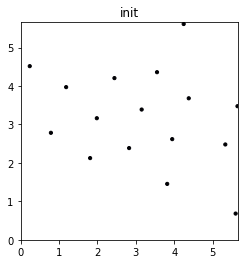

In [3]:
# t_tr contains the times corresponding to the stored energies and pressures, 
# but onfigurations were stored less frequently

# As a consequence we need to skip all the intermediate times in t_tr 
# for which we have no data in x_tr and y_tr
#skip=int( (t_tr.size-1)/(x_tr.shape[0]-1) )
skip=1
print(skip)

MD.AnimateMDRun(t_tr[::skip],x_tr,y_tr,xBox=LBox,xpbc=True,yBox=LBox,ypbc=True,m=m)

Plot des trajectoires des différentes particules

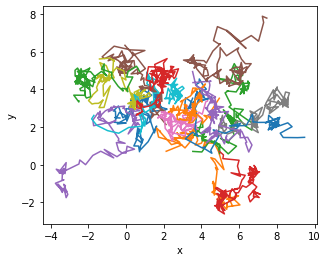

In [4]:
ax = plt.axes()
MD.AddParticleTraces(ax,x_tr,y_tr,range(NParticles))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)
plt.show()

## La fonction de corrélation des paires

### Etude de la fonction de corrélation pour une trajectoire dans l'espace des phases

In [3]:
# define system
d=2
NParticles=16
kT = 0.34
m = np.ones(NParticles)

# Lennard-Jones
sigma = 1
epsilon = 1
tau = sigma*np.sqrt(m[0]/epsilon) #unit of time
print('tau=',tau)

# choose density
rho = 0.5/sigma**d
print('Densité=', rho, 'sigma**',d)
LBox = np.power(NParticles/rho,1./d)
print("LBox = ",LBox)

# define the length of the trajectory
run_time = 100. * tau

# generate trajectories and measure execution time
initialWallTime = time.perf_counter()

( t_tr, x_tr, y_tr, vx_tr, vy_tr, uPot_tr, uKin_tr, pPot_tr, pKin_tr, pHyper_tr, [t,x,y,vx,vy] 
) = Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,LBox,kT,run_time)

print("Execution time: ",time.perf_counter() - initialWallTime)

tau= 1.0
Densité= 0.5 sigma** 2
LBox =  5.656854249492381
Execution time:  31.713333998000024


In [16]:
uSoloKin_tr = MD.ParticleKineticEnergies(m,vx_tr) + MD.ParticleKineticEnergies(m,vy_tr)
print(uSoloKin_tr)

[[0.66849195 0.08017766 0.13430916 ... 0.12429792 0.02213821 0.12969967]
 [0.27518387 0.4073106  0.85405131 ... 0.17819343 1.6690038  0.64130521]
 [0.45714793 0.97001093 1.03120031 ... 0.46627686 0.52961669 0.16579791]
 ...
 [0.16777501 0.06164182 0.75455492 ... 0.46021158 0.38150105 0.40255187]
 [0.57592796 0.087205   0.20794525 ... 0.4139414  0.19748234 0.11707651]
 [0.11150792 0.57433526 0.92685459 ... 0.16889647 0.10015855 0.02838266]]


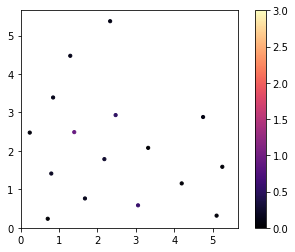

In [19]:
MD.PlotMDConf(x_tr[-1],y_tr[-1],xBox=(0,LBox),yBox=(0,LBox),xpbc=True,ypbc=True,m=m,c=uSoloKin_tr[-1])

16 particles in one configuration
100 data sets
r_range (0, 5)
bins 100
24000.0  pair distances
24000  expected
58904.86225480861 expected pair distances in an ideal gas


Text(0, 0.5, 'g(r)')

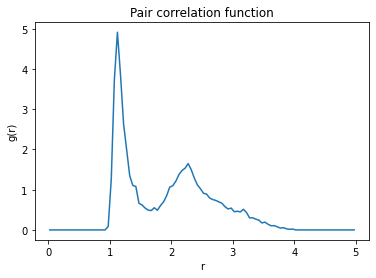

In [20]:
g, r_bin_edges = MD.Radial_distribution_function(2,LBox,(x_tr, y_tr),r_range=(0,5),bins=100,debug=True)

plt.plot(MD.BinCenters(r_bin_edges),g)
plt.title("Pair correlation function")
plt.xlabel("r")
plt.ylabel("g(r)")

Text(0, 0.5, 'N(r)')

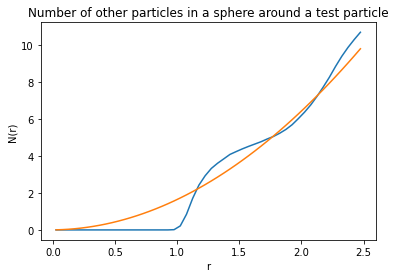

In [25]:
last_bin = 50
number_of_neighbors_up_to_a_distance = np.cumsum(g*rho*MD.UnitHyperSphereSurface(d)*MD.BinCenters(r_bin_edges)**(d-1)*(r_bin_edges[1]-r_bin_edges[0]))
ideal_number_of_neighbors_up_to_a_distance = np.cumsum(rho*MD.UnitHyperSphereSurface(d)*MD.BinCenters(r_bin_edges)**(d-1)*(r_bin_edges[1]-r_bin_edges[0]))
plt.plot(MD.BinCenters(r_bin_edges)[:last_bin],number_of_neighbors_up_to_a_distance[:last_bin])
plt.plot(MD.BinCenters(r_bin_edges)[:last_bin],ideal_number_of_neighbors_up_to_a_distance[:last_bin])
plt.title("Number of other particles in a sphere around a test particle")
plt.xlabel("r")
plt.ylabel("N(r)")

### Génération d'un ensemble de trajectoires à $kT$ et $\rho$ fixés

In [2]:
# define system
NParticles=16
d=2
kT = .5
m = np.ones(NParticles)
sigma = 1
epsilon = 1
#unit of time
tau = sigma*np.sqrt(m[0]/epsilon)      

# density
rho = 0.5/sigma**d
LBox = np.power(NParticles/rho,1/2)
print('kT=',kT)
print('rho=',rho)
print("LBox = ",LBox)

# define the length of the trajectory
run_time = 100. * tau

# define number of independent trajectories
NTrajectories = 5
print('Nombre de simulations:', NTrajectories)

# generate trajectories and measure execution time
initialWallTime = time.perf_counter()

(t_tr_ens, x_tr_ens, y_tr_ens, vx_tr_ens, vy_tr_ens,
 uPot_tr_ens, uKin_tr_ens, pPot_tr_ens, pKin_tr_ens, pHyper_tr_ens,
 list_of_starting_configurations
) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,run_time)

print("Execution time: ",time.perf_counter() - initialWallTime)

kT= 0.5
rho= 0.5
LBox =  5.656854249492381
Nombre de simulations: 5
Execution time:  110.45036134


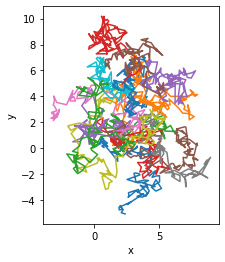

In [27]:
#Tracé de la trajectoire des particules pour 1 simulation, check up
ax = plt.axes()
Traj=1
MD.AddParticleTraces(ax,x_tr_ens[Traj],y_tr_ens[Traj],range(NParticles))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)
plt.show()

Ici on a une fonction qui renvoie directement la moyenne des compressibilités et l'écart type divisé par le nombre de trajectoires

### Balayage en température à $\rho$ fixé

In [76]:
rho_range=np.array([0.5])
kT_range = np.linspace(0.1,0.5,15)
print(kT_range)

[0.1        0.12857143 0.15714286 0.18571429 0.21428571 0.24285714
 0.27142857 0.3        0.32857143 0.35714286 0.38571429 0.41428571
 0.44285714 0.47142857 0.5       ]


In [77]:
# When in doubt use a small number of particles to speed up the simulations
# In a perfect world (as opposed to an exam), we would generate data for different systems sizes 
# and study finite size effects.

NParticles = 64
m = np.ones(NParticles)
d = 2

# Not much fun, if we reduce this even further
NTrajectories = 10
run_time_equilibration = 2
run_time_data_acquisition = 20

print("One sweep over all state points corresponds to ", rho_range.size * kT_range.size * NTrajectories," separate simulations!")

# On my computer each of the for "sweeps" below took 2 minutes. If you are worried about time try first with
# NTrajectories = 1

One sweep over all state points corresponds to  150  separate simulations!


In [78]:
# Create empty dictionaries for the data generated by MD simulations at specific state points
t_tr_ens_from_NVT_heating = {}
x_tr_ens_from_NVT_heating = {}
y_tr_ens_from_NVT_heating = {}
vx_tr_ens_from_NVT_heating = {}
vy_tr_ens_from_NVT_heating = {}
uPot_tr_ens_from_NVT_heating = {}
uKin_tr_ens_from_NVT_heating = {}
pPot_tr_ens_from_NVT_heating = {}
pKin_tr_ens_from_NVT_heating = {}
pHyper_tr_ens_from_NVT_heating = {}
list_of_starting_configurations_from_NVT_heating = {}


# generate trajectories and measure execution time
initialWallTime = time.perf_counter()

# sweep over densities
for rho in rho_range:
    
    # re-initialize starting configurations
    list_of_starting_configurations=[]
    for n in range(NTrajectories): 
            list_of_starting_configurations.append([])    
    

    # sweep over temperatures
    for kT in kT_range:
        i=0
        print("rho = ",rho,", kT = ",kT)
        
        # Box size
        LBox = np.power(NParticles/rho,1./d)


        # Equilibrate
        # ... reset velocities more often and hope for the best
        (t_tr_ens, x_tr_ens, y_tr_ens, vx_tr_ens, vy_tr_ens,
         uPot_tr_ens, uKin_tr_ens, pPot_tr_ens, pKin_tr_ens, pHyper_tr_ens,
         list_of_starting_configurations
        ) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,
                                                                       run_time_equilibration,
                                                                       list_of_starting_configurations=list_of_starting_configurations,
                                                                       number_of_time_steps_between_velocity_resets=10)

        key = (NParticles,str(round(rho,3)),str(round(kT,2)))
        # using floats as key can lead to difficulties, because of their inexact representation
        print('key=',key)
                # Generate data
        run_time = 50. *tau
        (t_tr_ens_from_NVT_heating[key], 
         x_tr_ens_from_NVT_heating[key], 
         y_tr_ens_from_NVT_heating[key], 
         vx_tr_ens_from_NVT_heating[key], 
         vy_tr_ens_from_NVT_heating[key],
         uPot_tr_ens_from_NVT_heating[key], 
         uKin_tr_ens_from_NVT_heating[key], 
         pPot_tr_ens_from_NVT_heating[key], 
         pKin_tr_ens_from_NVT_heating[key],
         pHyper_tr_ens_from_NVT_heating[key],
         list_of_starting_configurations_from_NVT_heating[key]
        ) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,
                                                                       run_time_data_acquisition,
                                                                       list_of_starting_configurations=list_of_starting_configurations)

print("Execution time: ",time.perf_counter() - initialWallTime)

rho =  0.5 , kT =  0.1
key= (64, '0.5', '0.1')
rho =  0.5 , kT =  0.1285714285714286
key= (64, '0.5', '0.13')
rho =  0.5 , kT =  0.15714285714285714
key= (64, '0.5', '0.16')
rho =  0.5 , kT =  0.18571428571428572
key= (64, '0.5', '0.19')
rho =  0.5 , kT =  0.2142857142857143
key= (64, '0.5', '0.21')
rho =  0.5 , kT =  0.24285714285714288
key= (64, '0.5', '0.24')
rho =  0.5 , kT =  0.27142857142857146
key= (64, '0.5', '0.27')
rho =  0.5 , kT =  0.30000000000000004
key= (64, '0.5', '0.3')
rho =  0.5 , kT =  0.3285714285714286
key= (64, '0.5', '0.33')
rho =  0.5 , kT =  0.3571428571428572
key= (64, '0.5', '0.36')
rho =  0.5 , kT =  0.3857142857142858
key= (64, '0.5', '0.39')
rho =  0.5 , kT =  0.41428571428571437
key= (64, '0.5', '0.41')
rho =  0.5 , kT =  0.44285714285714284
key= (64, '0.5', '0.44')
rho =  0.5 , kT =  0.4714285714285714
key= (64, '0.5', '0.47')
rho =  0.5 , kT =  0.5
key= (64, '0.5', '0.5')
Execution time:  2498.0000992759997


In [79]:
pHyper_tr_ens_from_NVT_heating

{(64,
  '0.5',
  '0.1'): array([[-1.02371538, -1.01374395, -1.00219555, ..., -0.13410467,
         -0.13178932, -0.13101735],
        [-1.01242746, -1.00395469, -0.99293543, ..., -0.17485829,
         -0.17547323, -0.17625533],
        [-0.98545082, -0.99307928, -1.00006066, ..., -0.01773961,
         -0.04000759, -0.06617517],
        ...,
        [-0.99044776, -0.97651308, -0.96292317, ..., -0.24773936,
         -0.25130736, -0.25315173],
        [-1.00071044, -0.9980443 , -0.99268171, ..., -0.29122496,
         -0.29371851, -0.29416941],
        [-1.00942974, -1.01786676, -1.02580158, ..., -0.45637049,
         -0.44794473, -0.43976675]]),
 (64,
  '0.5',
  '0.13'): array([[-0.02595232, -0.00132024,  0.02188921, ..., -0.05366683,
         -0.06407506, -0.07477736],
        [ 0.07106001,  0.06428399,  0.05160262, ..., -0.38240135,
         -0.35261963, -0.32312243],
        [-0.16578225, -0.13943469, -0.1212729 , ..., -0.02882931,
         -0.01877928, -0.01331726],
        ...,
     

In [80]:
compressibility_from_NVT_heating=[]

#Compressibility_from_pressure_fluctuations_in_NVT(d,m,NParticles,LBox,kT,pPot_tr_ens, pHyper_tr_ens)

for i in range(len(kT_range)):
    
    key=((NParticles,str(round(rho,3)),str(round(kT_range[i],2))))
    print(key)
    compr_Ntraj_fixedkT = Compressibility_from_pressure_fluctuations_in_NVT(d,m,NParticles,LBox,kT,pPot_tr_ens_from_NVT_heating[key], pHyper_tr_ens_from_NVT_heating[key])
    print(compr_Ntraj_fixedkT)
    compressibility_from_NVT_heating.append(compr_Ntraj_fixedkT)
    
print(compressibility_from_NVT_heating)

(64, '0.5', '0.1')
(-0.12035249679563238, 0.006733713905342137)
(64, '0.5', '0.13')
(-0.20280381861608138, 0.015613158873458027)
(64, '0.5', '0.16')
(-0.16555653828963854, 0.006416636137187226)
(64, '0.5', '0.19')
(-0.11761528310850969, 0.004239753831128466)
(64, '0.5', '0.21')
(-0.1261442149739424, 0.00578241263684115)
(64, '0.5', '0.24')
(-0.10923681265750407, 0.0061464852066703286)
(64, '0.5', '0.27')
(-0.10623004787839471, 0.006059151863222144)
(64, '0.5', '0.3')
(-0.09889918302304727, 0.005455036528473426)
(64, '0.5', '0.33')
(-0.09200327293918185, 0.00381987412444537)
(64, '0.5', '0.36')
(-0.08841877953464408, 0.0031189469972944476)
(64, '0.5', '0.39')
(-0.08162504193121771, 0.003457265507184713)
(64, '0.5', '0.41')
(-0.0810383038380565, 0.002893111775174365)
(64, '0.5', '0.44')
(-0.07636409516438504, 0.0034819482323548805)
(64, '0.5', '0.47')
(-0.07222101740701814, 0.0022582328965523746)
(64, '0.5', '0.5')
(-0.07491012035443452, 0.0016767151836788628)
[(-0.12035249679563238, 0.0

In [81]:
mean_compressibility_from_NVT_heating=[]
dispersion_compressibility_from_NVT_heating=[]
for i in range(len(kT_range)):
    mean_compressibility_from_NVT_heating.append(compressibility_from_NVT_heating[i][0])
    dispersion_compressibility_from_NVT_heating.append(compressibility_from_NVT_heating[i][1])

Text(0.5, 0, 'Température')

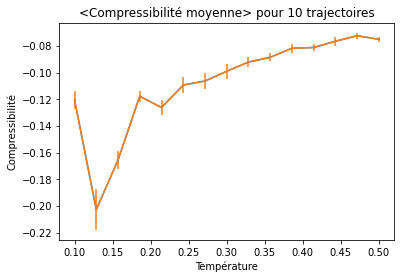

In [82]:
plt.plot(kT_range,mean_compressibility_from_NVT_heating)
plt.errorbar(kT_range,mean_compressibility_from_NVT_heating,dispersion_compressibility_from_NVT_heating)
plt.title('<Compressibilité moyenne> pour {} trajectoires'.format(NTrajectories))
plt.ylabel('Compressibilité')
plt.xlabel('Température')


On a :

$\mathrm{d} V=-\chi_{T} V \mathrm{~d} P$

Donc on peut tracer les isothermes et former un Clapeyron